In [1]:
import util.util as bench
import models.SNPLogisticRegression as models
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.model_selection import train_test_split
from encrypt.ckks import *
from sklearn.metrics import accuracy_score


In [2]:
_r = lambda x: np.round(x, decimals=3)

num_benchs = 100
n = 100
m = 10
k = 3

# semi-parallel log regression with covariates

### fit regression with const matrix(covariates are the same for each SNP for one person), then do 1 iteration of Newton-Rhapsod(NR) with SNP term in regression.

semi-parallel approach is realized in firstly doing one regression with covariates for all SNPs and then doing one iteration of NR for all SNP simultaneously(calculate S_star and not for each column of S separately)

In [15]:
semi_parallel_model = models.SemiParallelSNPLogRegression()
bench_res = bench.bench_model(semi_parallel_model, num_benchs, n, m, k)
msips_paral = bench_res["msip"]
print(f"Semi-parallel approach average speed: {msips_paral.mean():.2f} Msips\n")

Semi-parallel approach average speed: 39.08 Msips



__NOTES__: somehow changing size of problem(not k) affects speed in msips(which it shouldnt, as far as i know..)

__NOTE REMARK__: source code in R also does this, however paper states
"Computation time for GWAS is linear in sample size and in the number of investigated SNPs.
... One should keep in mind that due to the imprecision of proc.time and its variability from run to run, 
the calculated times/speeds are only approximate. "

### non semi-parallel approach - fit regression for each SNP separately

In [19]:
brute_force_model = models.BruteForceSNPLogRegression()
bench_res = bench.bench_model(brute_force_model, num_benchs, n, m, k)
msips_brute = bench_res["msip"]
print(f"Brute force approach average speed: {msips_brute.mean():.2f} Msips\n")

Brute force approach average speed: 0.23 Msips



In [20]:
print(f"Semi-parallel is {msips_paral.mean() / msips_brute.mean():.2f} times faster")

Semi-parallel is 164.76 times faster


<Figure size 640x480 with 0 Axes>

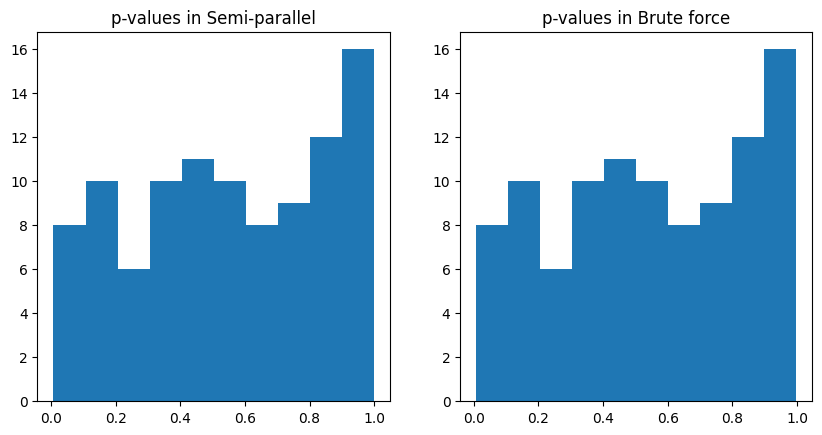

<Figure size 640x480 with 0 Axes>

In [3]:
y, S, X = bench.gen_random_data(2013, n, m, k)
semi_par = models.SemiParallelSNPLogRegression()
semi_par.fit(y,S,X)

brute_forc = models.BruteForceSNPLogRegression()
brute_forc.fit(y,S,X)

fig, axes = plt.subplots(1,2)
fig.set_figwidth(10)
axes[0].hist(semi_par.pvalues)
axes[0].set_title("p-values in Semi-parallel")
axes[0].axis()

axes[1].hist(brute_forc.pvalues)
axes[1].set_title("p-values in Brute force")

plt.figure()

### Difference in p-values predicted by exact and approximate alglorithms

Text(0, 0.5, 'p-values brute force')

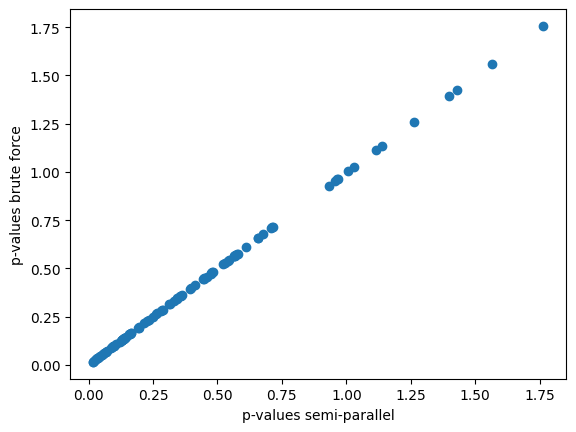

In [30]:
h = 100
pval_par = np.zeros(h)
pval_brute = np.zeros(h)

semi_par = models.SemiParallelSNPLogRegression()
brute_forc = models.BruteForceSNPLogRegression()
n = 1000
m = 1
k = 5

for i in range(h):
    y, S, X = bench.gen_random_data(i, n, m, k)
    brute_forc.fit(y,S,X)
    semi_par.fit(y,S,X)
    # each time we can in general select random snp to be representing algorithm's run on dataset
    # we cant take all of snps from each run as covariates are the same
    rand_snp = np.random.randint(0,m)
    pval_par[i] = semi_par.pvalues[rand_snp]
    pval_brute[i] = brute_forc.pvalues[rand_snp]

       
plt.plot(-np.log10(pval_par),-np.log10(pval_brute),'o')
plt.xlabel("p-values semi-parallel")
plt.ylabel("p-values brute force")

__NOTES__: in original paper authors managed to generate data on which pvalues would get as low as $10^-40$
and i'm not sure how to reproduce that. However, the linear dependancy starts to go off at pvalues lowerv than $10^-25$ but getting
pvalues as low as that in a real-world scenario is practically insignificant so it doesnt really matter 

In [ ]:
# finding real dataset turned out to be more challenging than it first appeared...

In [15]:
import vcf
vcf_reader = vcf.Reader(filename='data/centro.vcf.gz')
rec = next(vcf_reader)
rec = next(vcf_reader)
rec = next(vcf_reader)
samples = rec.samples
print(rec.CHROM,rec.REF, rec.ALT, rec.POS)
GTs = []
for sample in samples:
    GTs.append(sample["GT"])
print(GTs)

3L A [T] 361
['1/1', '0/0', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', '0/0', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/0', './.', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '1/1', '0/0', '0/0', '0/0', '0/0', '0/0', './.', './.', '0/0', '0/0', './.', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', './.', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/0', '0/1', './.', '0/0', '1/1', '0/0']


# Trying out pyfhel

In [32]:
ckks_params = {
    'scheme': 'CKKS',   # can also be 'ckks'
    'n': 2**15,         # Polynomial modulus degree. For CKKS, n/2 values can be
                        #  encoded in a single ciphertext.
                        #  Typ. 2^D for D in [10, 16]
    'scale': 2**56,     # All the encodings will use it for float->fixed point
                        #  conversion: x_fix = round(x_float * scale)
                        #  You can use this as default scale or use a different
                        #  scale on each operation (set in HE.encryptFrac)
    'qi_sizes': [60, 56, 56, 56, 56, 56, 60] # Number of bits of each prime in the chain.
                        # Intermediate values should be  close to log2(scale)
                        # for each operation, to have small rounding errors.
}

ckks = CKKS(ckks_params, 100, 100, 3)
x = [np.array([1,2,3],dtype=np.float64),np.array([4,5,6],dtype=np.float64)]
y = [np.array([4,5],dtype=np.float64),np.array([7,8],dtype=np.float64),np.array([10,11],dtype=np.float64)]
x = np.array(x).T
y = np.array(y).T
xct = list()
yct = list()
for i in range(3):
    xct.append(ckks.he.encrypt(x[i]))
for i in range(2):
    yct.append(ckks.he.encrypt(y[i]))



In [34]:

sigmoid_pure = lambda x: 1 / (1 + np.exp(-x))
sigmoid_appr_3 = lambda x: 0.5 - 1.73496 * (x/8) + 4.19407 * (x / 8)**3 
# - 5.43402 * (x / 8)**5 + 2.50739 * (x / 8)**7 if (np.abs(x) < 10).all() else np.ones(len(x))
sigmoid_appr_5 = lambda x: 0.5 - 1.73496 * (x/8) + 4.19407 * (x / 8)**3 - 5.43402 * (x / 8)**5 
# + 2.50739 * (x / 8)**7 if (np.abs(x) < 10).all() else np.ones(len(x))
for x in [i*0.1 for i in range(10)]:
    err3 = (sigmoid_pure(x) - sigmoid_appr_3(x))/sigmoid_pure(x)
    err5 = (sigmoid_pure(x) - sigmoid_appr_5(x)) / sigmoid_pure(x)
    print(f"deg3:{err3}; deg5:{err5}; diff:{err5-err3}")

deg3:0.0; deg5:0.0; diff:0.0
deg3:0.08887589650940778; deg5:0.08887589966825929; diff:3.1588515136959927e-09
deg3:0.16940106545611414; deg5:0.16940116196997437; diff:9.651386023712405e-08
deg3:0.24246524425901606; deg5:0.24246594576437785; diff:7.015053617998035e-07
deg3:0.30886122043624537; deg5:0.30886405685891305; diff:2.8364226676846904e-06
deg3:0.3692938266134164; deg5:0.3693021521136524; diff:8.325500235994987e-06
deg3:0.4243882237382198; deg5:0.4244081959495269; diff:1.997221130706217e-05
deg3:0.4746975118994798; deg5:0.4747392240877304; diff:4.171218825060885e-05
deg3:0.5207097087713356; deg5:0.5207884655971116; diff:7.875682577596077e-05
deg3:0.5628541356640533; deg5:0.5629918709103724; diff:0.00013773524631910394


In [68]:



from math import inf
def simple_log_reg(y,X,alpha=2**-6,max_iters=20,tolerance=1e-8):
    n = X.shape[0]
    k = X.shape[1]
    xtx_inv = np.linalg.inv(X.T @ X)
    beta = np.array([1e8] * k).reshape(k,1)
    beta_next = np.ones(k).reshape(k,1) * 0.1
    p = np.ones(n).reshape(n,1) * 0.5
    iter = 0
    while iter < max_iters and np.linalg.norm(beta_next - beta,2) > tolerance:
        H_inv = 4 * xtx_inv
        g = X.T @ (y - p)
        # w = p * (1 - p)
        # H_inv = np.linalg.inv((X * w).T @ X) 
        beta = beta_next
        beta_next = beta + alpha * H_inv @ g
        iter += 1
        p = sigmoid_appr_5(X @ beta_next).reshape(n,1)
        print(f"{iter}:{np.max((X @ beta_next))}")
    print("iters:",iter)
    return beta_next

def simple_log_reg_grad_desc(y,X):
    n = X.shape[0]
    k = X.shape[1]
    Z = y * X
    beta = np.array([1e8] * k).reshape(k,1)
    beta_next = np.zeros(k).reshape(k,1)
    tolerance = 1e-8
    max_iters = 100
    iter = 0
    while iter < max_iters:
        grad =  1 / n * np.sum(sigmoid_pure(-Z @ beta_next).reshape(n,1) * Z, axis=0).reshape(k,1)
        alpha = 0.1
        beta = beta_next
        beta_next = beta + alpha * grad
        iter += 1
        print(np.linalg.norm(beta-beta_next,2))
    print("iters:",iter)
    return beta_next

def predict(beta,X):
    return sigmoid_appr_3(X @ beta)

# import statsmodels.api as sm

# y, S, X = bench.gen_random_data(2013, 100, 10, 10) 
# my_beta = simple_log_reg_grad_desc(y,X)
# beta_pure = sm.GLM(y, X, family=sm.families.Binomial()).fit().params.reshape(11,1)
# print(my_beta - beta_pure)

In [70]:
from sklearn.linear_model import LogisticRegression
n=1000
m=10
k=5
y,X,S = bench.gen_random_data(2013,n,m,k,False)
X_data = X
y_data = y.reshape(n)

x_train, x_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42)
x_train_bias = np.append((np.zeros(x_train.shape[0]) + 1).reshape(x_train.shape[0],1),x_train,axis=1)
x_test_bias = np.append((np.zeros(x_test.shape[0]) + 1).reshape(x_test.shape[0],1),x_test,axis=1)


my_beta = simple_log_reg(y_train.reshape(x_train_bias.shape[0],1),x_train_bias)
sklearn_regr = LogisticRegression(solver='newton-cg', max_iter=100)
sklearn_regr.fit(x_train, y_train)


pred_sklearn = sklearn_regr.predict(x_test)
accuracy_skleanr = accuracy_score(y_test, pred_sklearn)
my_pred = np.array([1 if p > 0.5 else 0 for p in predict(my_beta,x_test_bias)])
my_accuracy = accuracy_score(y_test,my_pred)
print(accuracy_skleanr)
print(my_accuracy)

1:1.0183377955068573
2:1.0262840125226242
3:1.0342821080988929
4:1.0423323896002026
5:1.05043516551481
6:1.058590745443029
7:1.0667994400851444
8:1.0750615612288992
9:1.0833774217365426
10:1.0917473355314344
iters: 10
0.49
0.46


In [2]:
ckks_params = {
    'scheme': 'CKKS',   # can also be 'ckks'
    'n': 2**15,         # Polynomial modulus degree. For CKKS, n/2 values can be
                        #  encoded in a single ciphertext.
                        #  Typ. 2^D for D in [10, 16]
    'scale': 2**56,     # All the encodings will use it for float->fixed point
                        #  conversion: x_fix = round(x_float * scale)
                        #  You can use this as default scale or use a different
                        #  scale on each operation (set in HE.encryptFrac)
    'qi_sizes': [60, 56, 56, 56, 56, 56, 60] # Number of bits of each prime in the chain.
                        # Intermediate values should be  close to log2(scale)
                        # for each operation, to have small rounding errors.
}
n=10
m=10
k=3
ckks = CKKS(ckks_params, n, m, k)


y,X,S = bench.gen_random_data(2013,n,m,k,False)
xtx_inv = (X @ X.T) ** (-1)
xt_enc = list()
x_enc = list()
xtx_inv_enc = list()
for i in range(k):
    x_enc.append(ckks.he.encrypt(X.T[i]))
for i in range(n):
    xt_enc.append(ckks.he.encrypt(X[i]))
    xtx_inv_enc.append(ckks.he.encrypt(xtx_inv.T[i]))
y_enc = ckks.he.encrypt(y.reshape(n))


In [3]:

def simple_log_reg_enc(y,X,XT,XTX_inv,n,k,alpha = 2**-6, max_iters=5):
    alpha = ckks.he.encrypt(np.array([alpha] * n))
    beta = ckks.he.encrypt(np.ones(k) * 0.1)
    beta_next = copy.deepcopy(beta)
    H_inv = list()
    for column in XTX_inv:
        H_inv.append(ckks.he.encrypt(np.array([4]*n)) * column) # H_inv = 4 * XTX_inv

    for i in range(max_iters):
        p = ckks.sigmoid(ckks.mat_vec_mult(X,beta_next,k))
        g = ckks.mat_vec_mult(XT,y-p,n)
        beta = beta_next
        beta_next = beta + alpha * ckks.mat_vec_mult(H_inv,g,n)
        ckks.he.relinearize(beta_next)
        ckks.he.rescale_to_next(beta_next)
    return beta_next
beta_enc = simple_log_reg_enc(y_enc,x_enc,xt_enc,xtx_inv_enc,n,k + 1)
print(ckks.he.decrypt(beta_enc))

RuntimeError: <Afseal>: CKKS context not initialized